# Addressing Imbalance in Stroke Prediction Models: A Comparative Study of Undersampling and Oversampling Techniques with XGBoost


##1.Problem Definition
Class imbalance is a prevalent issue in healthcare datasets, including those used for stroke prediction. In these datasets, the majority class (e.g., patients without stroke) often vastly outnumbers the minority class (e.g., patients with stroke), leading to biased model predictions that favor the majority class. As a result, models may perform poorly in identifying minority class instances, which are typically of greater clinical significance.

The objective of this study is to address the challenge of class imbalance in stroke prediction datasets by exploring and comparing the effectiveness of various undersampling and oversampling techniques. The focus is to improve the performance of the XGBoost model in predicting the minority class while maintaining overall model reliability. This research aims to provide actionable insights into handling class imbalance in healthcare applications, ensuring accurate and fair predictions for critical medical conditions like stroke.

### Objectives

### 1. Evaluate Model Performance on Imbalanced Data
Assess how the model performs when trained on imbalanced data without any adjustments, highlighting the baseline challenges.

### 2. Explore Oversampling Techniques
Apply various oversampling strategies to mitigate class imbalance, including:

- **Random Oversampling:** Randomly replicates minority class instances to achieve balance.  
- **SMOTE (Synthetic Minority Over-Sampling Technique):** Generates synthetic samples for the minority class by interpolating between existing examples.  
- **ADASYN (Adaptive Synthetic Sampling):** Enhances SMOTE by focusing on harder-to-learn examples, generating more synthetic data points in challenging regions.  
- **Borderline-SMOTE:** Creates synthetic data near the decision boundary of minority and majority classes to refine class separation.  
- **SVMSMOTE:** Employs support vector machines (SVM) to generate synthetic instances closer to the decision boundary.  
- **KMeans-SMOTE:** Utilizes KMeans clustering to identify informative clusters and balances the dataset by generating synthetic samples based on cluster centroids.  
- **SMOTEENN:** Combines SMOTE and Edited Nearest Neighbors (ENN) to both generate synthetic samples and remove noisy instances.  
- **SMOTETomek:** Integrates SMOTE and Tomek Links to synthesize samples and clean noisy examples for improved dataset quality.

### 3. Explore Undersampling Techniques
Investigate undersampling strategies to achieve class balance, categorized as follows:  

#### Prototype Generation
- **Cluster Centroids:** Synthesizes representative centroids from clusters using K-means, effectively reducing the dataset size.  

#### Prototype Selection  

##### Controlled Undersampling  
- **Random Undersampling:** Randomly selects a subset of samples from the majority class to match the minority class size.  
- **NearMiss:** Implements three variations of nearest-neighbor sampling:  
  - **NearMiss-1:** Selects majority samples with the smallest average distance to minority samples.  
  - **NearMiss-2:** Selects samples with the smallest average distance to farthest minority samples.  
  - **NearMiss-3:** Applies a two-step nearest-neighbor rule for sample selection.  

##### Cleaning Undersampling  
- **Tomek Links:** Removes noisy majority samples that are each other's nearest neighbors with minority samples.  
- **Edited Nearest Neighbors (ENN):** Eliminates majority samples misclassified by their nearest neighbors.  
- **Repeated Edited Nearest Neighbors (RENN):** Iterates ENN cleaning multiple times for thorough cleaning.  
- **All KNN:** Progressively increases neighborhood size during ENN iterations to enhance dataset quality.  
- **Condensed Nearest Neighbor (CNN):** Retains only difficult-to-classify samples based on a nearest-neighbor rule.  
- **One-Sided Selection (OSS):** Combines CNN and Tomek Links to remove noisy and redundant majority samples.  
- **Neighborhood Cleaning Rule (NCR):** Employs a combination of ENN and nearest-neighbor classification for advanced cleaning.  

#### Additional Techniques  
- **Instance Hardness Threshold:** Retains only those samples classified with high confidence, removing instances with low probabilities based on a specified classifier.  

### 4. Comparative Analysis
Compare model performance across original, oversampled, and undersampled datasets using evaluation metrics such as accuracy, precision, recall, F1-score, and AUC-ROC.

### 5. Insights and Recommendations
Identify the most effective techniques for improving model performance and provide practical recommendations for handling class imbalance in stroke prediction and similar healthcare datasets.

---

By systematically addressing class imbalance with these advanced techniques, this study aims to enhance the accuracy, reliability, and interpretability of XGBoost-based stroke prediction models, particularly in identifying critical minority class instances.


##2.Dataset

The dataset used in this project contains information necessary to predict the occurrence of a stroke. Each row in the dataset represents a patient, and the dataset includes the following attributes:

- **id:** Unique identifier
- **gender:** "Male", "Female", or "Other"
- **age:** Age of the patient
- **hypertension:** 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- **heart_disease:** 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- **ever_married:** "No" or "Yes"
- **work_type:** "Children", "Govt_job", "Never_worked", "Private", or "Self-employed"
- **Residence_type:** "Rural" or "Urban"
- **avg_glucose_level:** Average glucose level in the blood
- **bmi:** Body mass index
- **smoking_status:** "Formerly smoked", "Never smoked", "Smokes", or "Unknown"
- **stroke:** 1 if the patient had a stroke, 0 if not

##3.Data Inspecting and Preprocessing

In [41]:
# Install necessary libraries
!pip install -U imbalanced-learn
!pip install -U scikit-learn


In [42]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, auc, precision_score,
                             recall_score, f1_score)
from imblearn.over_sampling import (RandomOverSampler, SMOTE,
                                    ADASYN, BorderlineSMOTE,
                                    SVMSMOTE, KMeansSMOTE)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import (RandomUnderSampler, ClusterCentroids,
                                     NearMiss, TomekLinks,EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours,AllKNN,
                                     CondensedNearestNeighbour, OneSidedSelection,
                                     NeighbourhoodCleaningRule, InstanceHardnessThreshold)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [43]:
from google.colab import files
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data (1).csv


In [44]:
# Load DefaultCreditCardClients.xls
import pandas as pd
file_path = 'healthcare-dataset-stroke-data.csv'
data = pd.read_csv(file_path)
display(data.head())

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [45]:
# Check the shape of the dataset (#Rows, #Columns)
print("Shape of the dataset:")
print(data.shape)

Shape of the dataset:
(5110, 12)


In [46]:
# Check Dataset Information
print("Dataset Information:")
print(data.info)

Dataset Information:
<bound method DataFrame.info of          id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Pr

In [47]:
print("\nSummary Statistics:")
data.describe().T


Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [48]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [49]:
# Fill missing BMI values with the mean
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

In [50]:
# Check any duplicated values
print("\nDuplicated Values:")
print(data.duplicated().sum())


Duplicated Values:
0


In [51]:
# Analyze the distribution of the target variable
print("\nTarget Variable Distribution (stroke):")
print(data['stroke'].value_counts())


Target Variable Distribution (stroke):
stroke
0    4861
1     249
Name: count, dtype: int64


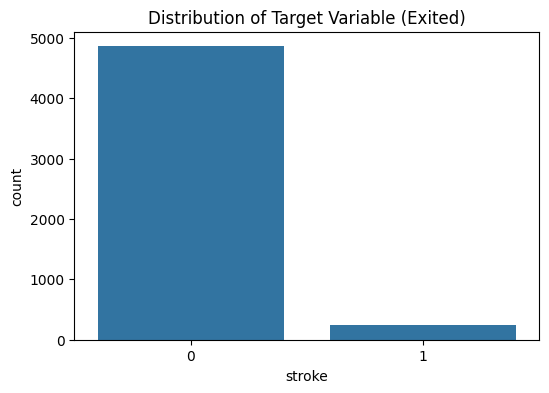

In [52]:
# Visualize the target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=data)
plt.title('Distribution of Target Variable (Exited)')
plt.show()

In [53]:
# Check datatypes
data.dtypes

,0
id,int64
gender,object
age,float64
hypertension,int64
heart_disease,int64
ever_married,object
work_type,object
Residence_type,object
avg_glucose_level,float64
bmi,float64


In [54]:
data['age'].astype(int)

,age
0,67
1,61
2,80
3,49
4,79
...,...
5105,80
5106,81
5107,35
5108,51


In [55]:
print(data['ever_married'].value_counts())

ever_married
Yes    3353
No     1757
Name: count, dtype: int64


In [56]:
print(data['work_type'].value_counts())

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


In [57]:
print(data['gender'].value_counts())

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


In [58]:
print(data['Residence_type'].value_counts())

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


In [59]:
print(data['smoking_status'].value_counts())

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


In [60]:
# Encode categorical variables
label_encoder = LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])
data['ever_married'] = label_encoder.fit_transform(data['ever_married'])
data['work_type'] = label_encoder.fit_transform(data['work_type'])
data['Residence_type'] = label_encoder.fit_transform(data['Residence_type'])
data['smoking_status'] = label_encoder.fit_transform(data['smoking_status'])


##4.Exploratory Data Analysis

###Correlation matrix

In [61]:
# Correlation matrix
print("\nCorrelation matrix:")
data.corr()


Correlation matrix:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,1.000000,0.002511,0.003538,0.003550,-0.001296,0.013690,-0.015757,-0.001403,0.001092,0.002999,0.014074,0.006388
gender,0.002511,1.000000,-0.028202,0.020994,0.085447,-0.031005,0.056422,-0.006738,0.055180,-0.026109,-0.062581,0.008929
age,0.003538,-0.028202,1.000000,0.276398,0.263796,0.679125,-0.361642,0.014180,0.238171,0.325942,0.265199,0.245257
hypertension,0.003550,0.020994,0.276398,1.000000,0.108306,0.164243,-0.051761,-0.007913,0.174474,0.160189,0.111038,0.127904
heart_disease,-0.001296,0.085447,0.263796,0.108306,1.000000,0.114644,-0.028023,0.003092,0.161857,0.038899,0.048460,0.134914
ever_married,0.013690,-0.031005,0.679125,0.164243,0.114644,1.000000,-0.352722,0.006261,0.155068,0.335705,0.259647,0.108340
work_type,-0.015757,0.056422,-0.361642,-0.051761,-0.028023,-0.352722,1.000000,-0.007316,-0.050513,-0.299448,-0.305927,-0.032316
Residence_type,-0.001403,-0.006738,0.014180,-0.007913,0.003092,0.006261,-0.007316,1.000000,-0.004946,-0.000120,0.008237,0.015458
avg_glucose_level,0.001092,0.055180,0.238171,0.174474,0.161857,0.155068,-0.050513,-0.004946,1.000000,0.168751,0.063437,0.131945
bmi,0.002999,-0.026109,0.325942,0.160189,0.038899,0.335705,-0.299448,-0.000120,0.168751,1.000000,0.219148,0.038947


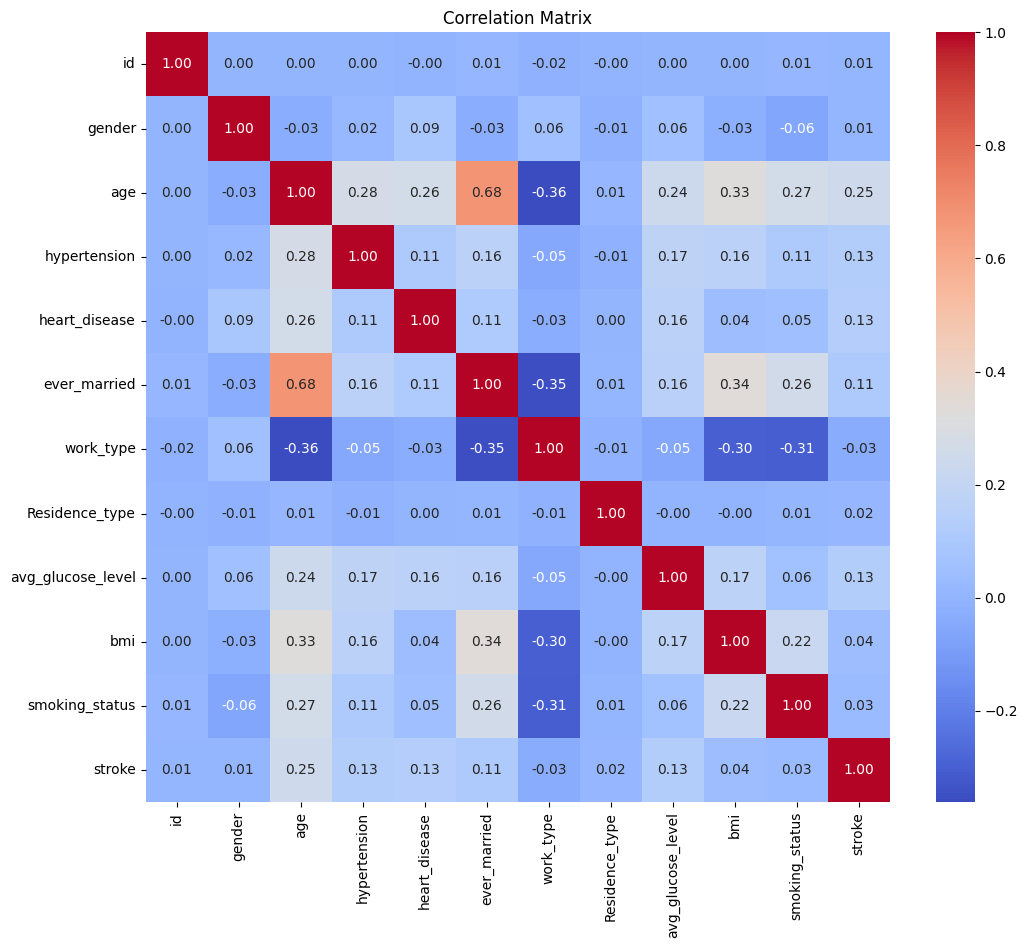

In [62]:
# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

###Distribution of numerical features

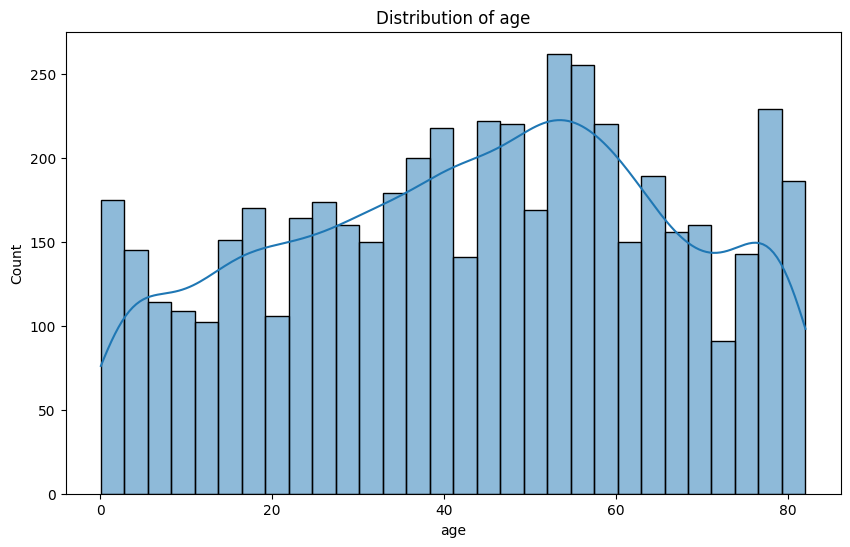

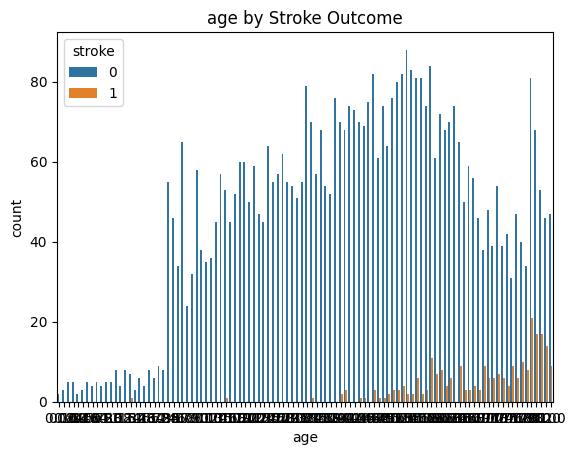

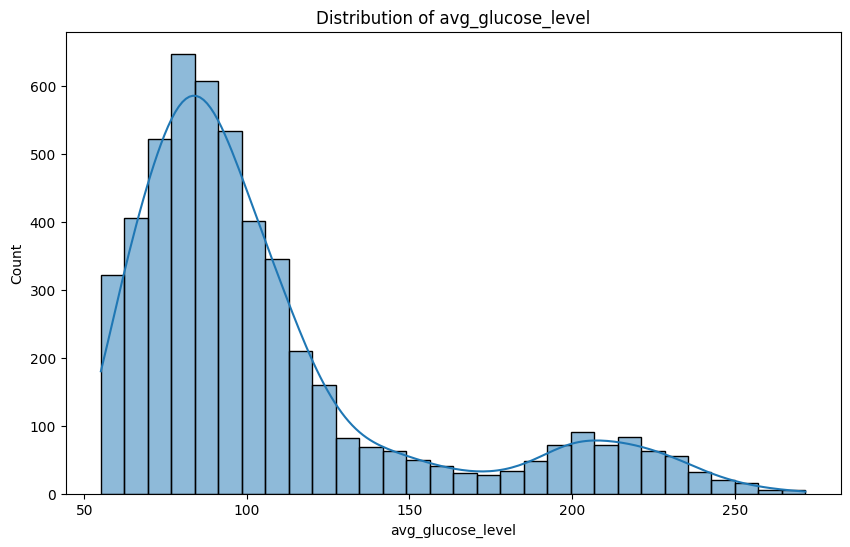

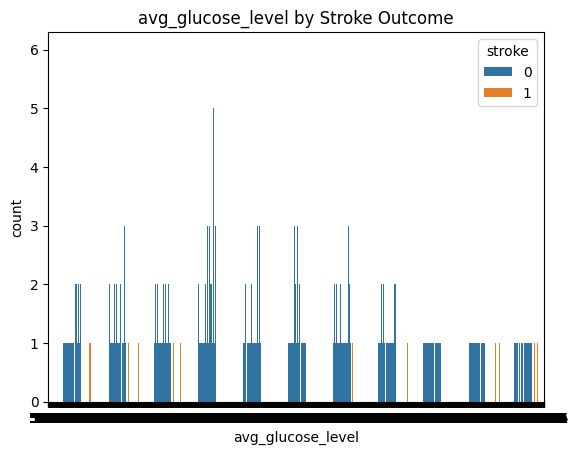

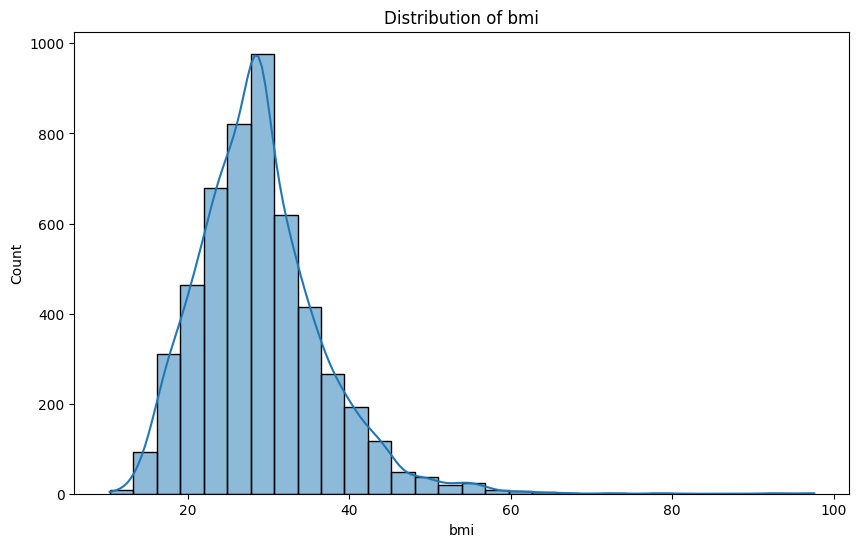

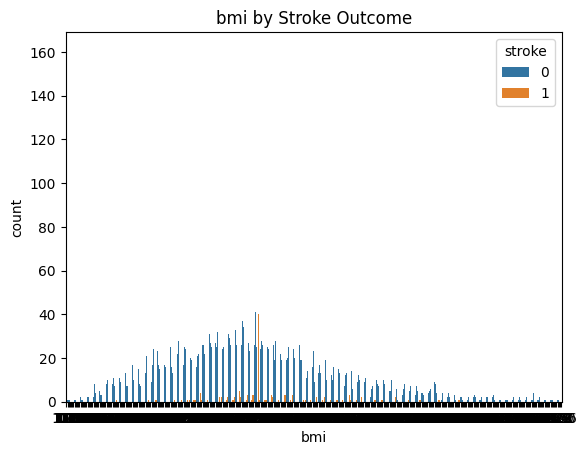

In [63]:
# Distribution of numerical features
numerical_features = ['age', 'avg_glucose_level', 'bmi']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()
    sns.countplot(x=feature, hue='stroke', data=data)
    plt.title(f'{feature} by Stroke Outcome')
    plt.show()

### Box plots of numerical features by stroke outcome

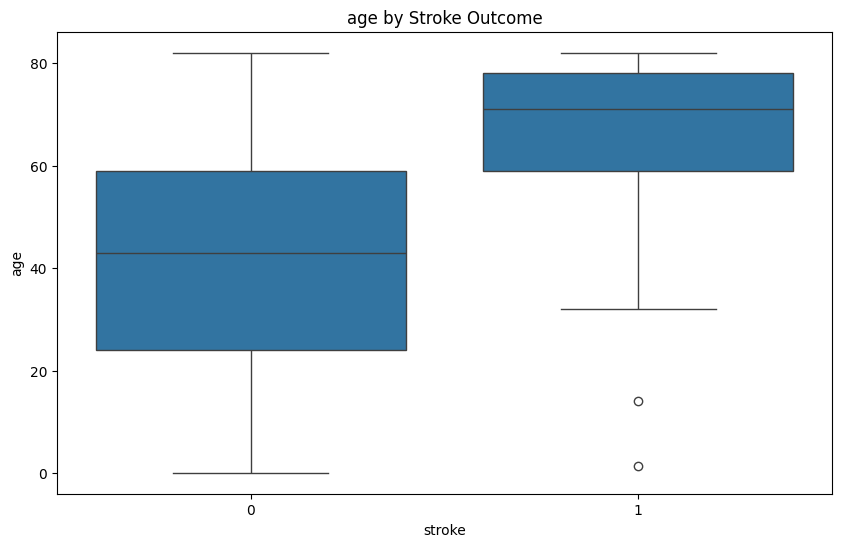

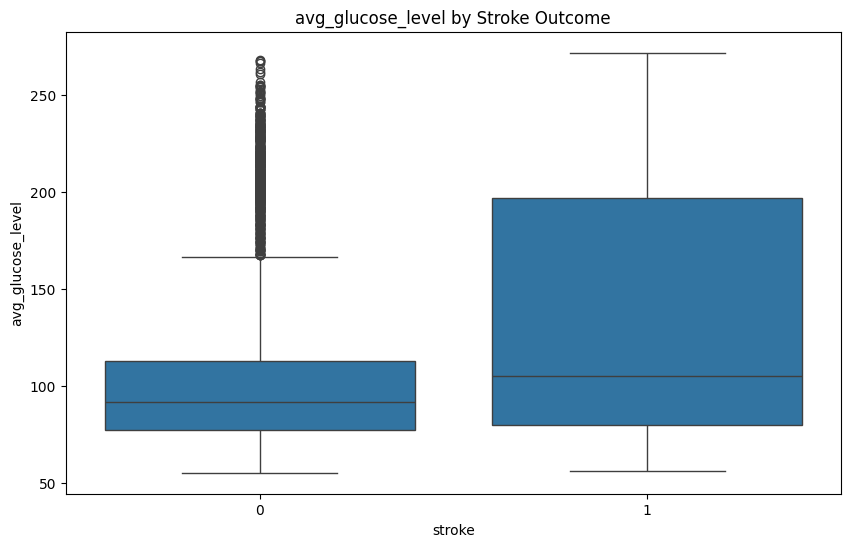

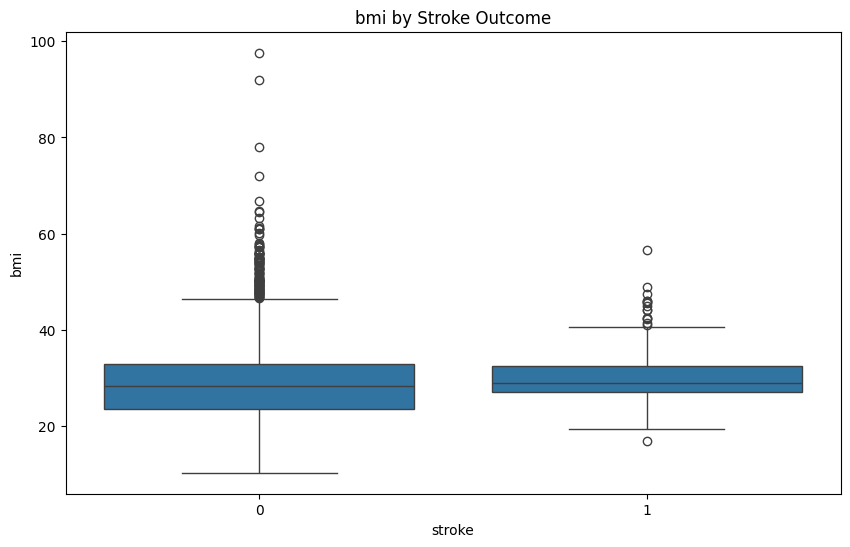

In [64]:
# Box plots of numerical features by stroke outcome
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='stroke', y=feature, data=data)
    plt.title(f'{feature} by Stroke Outcome')
    plt.show()

###Count plots of categorical features

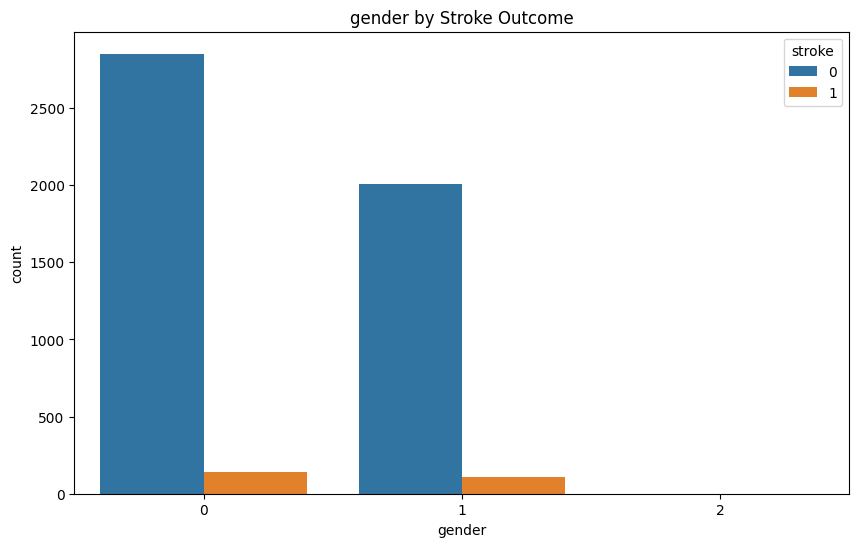

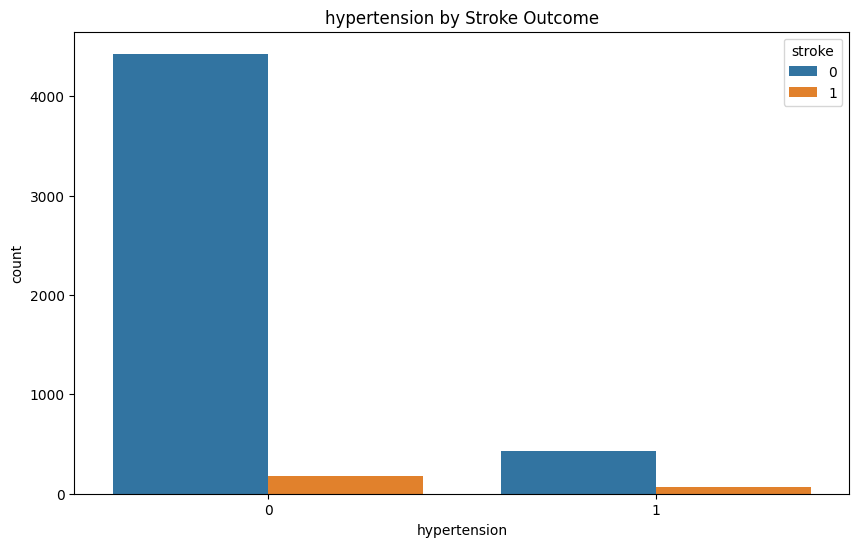

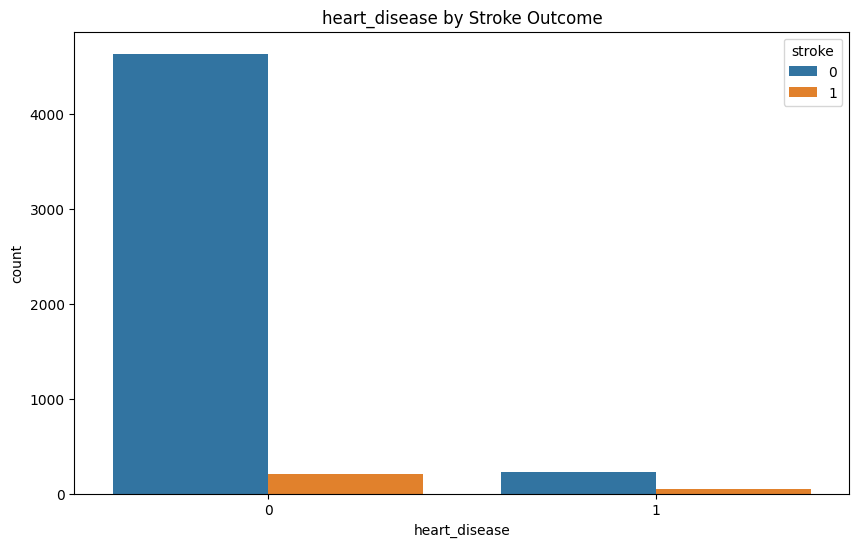

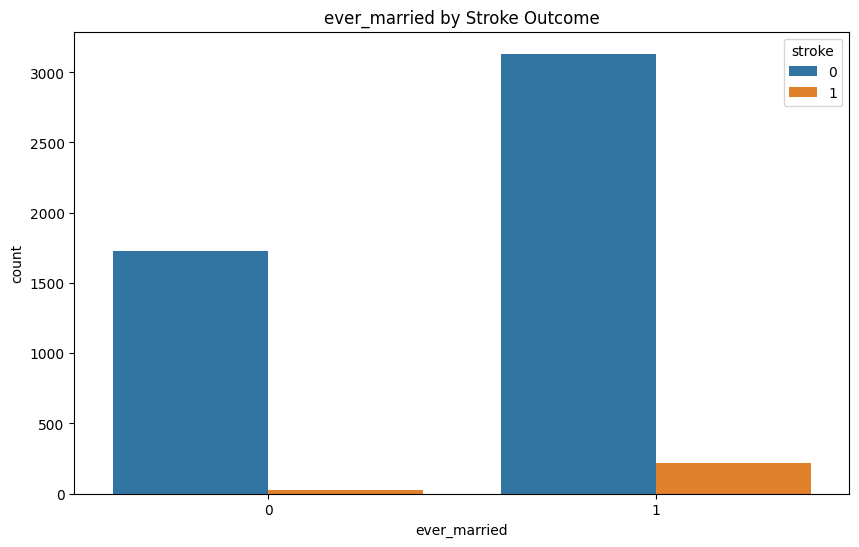

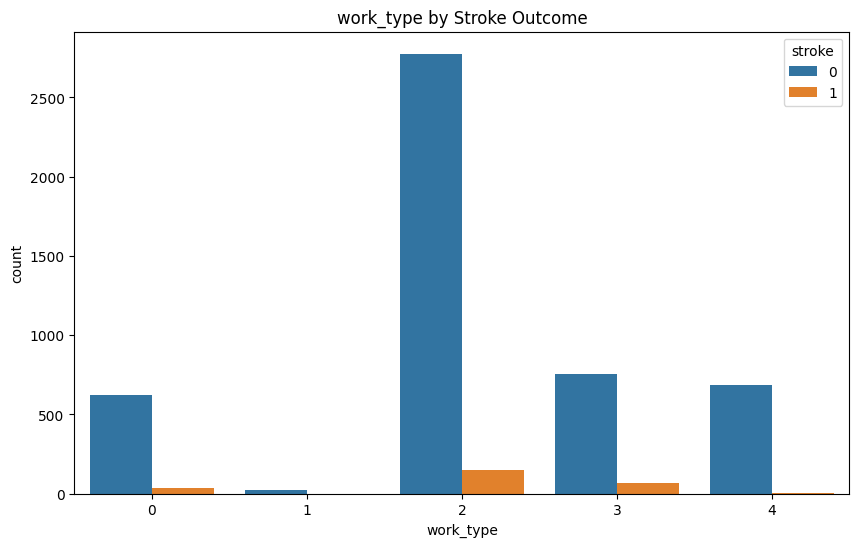

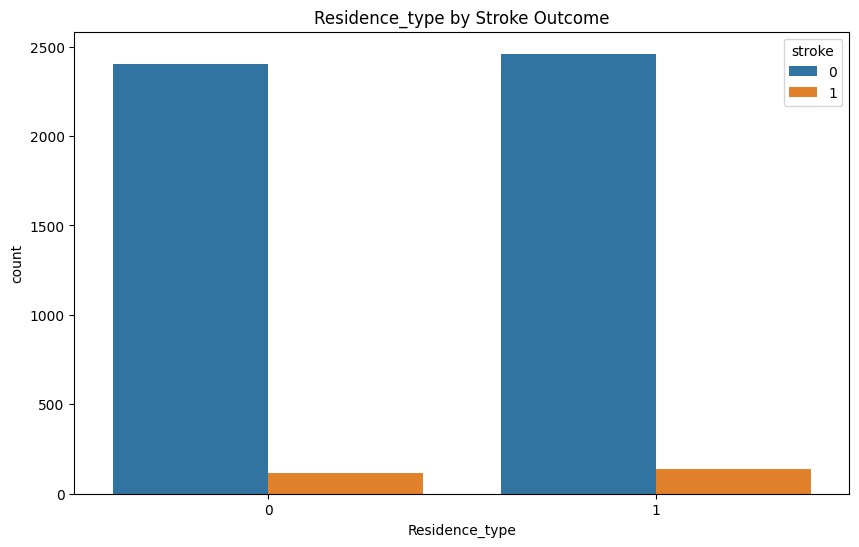

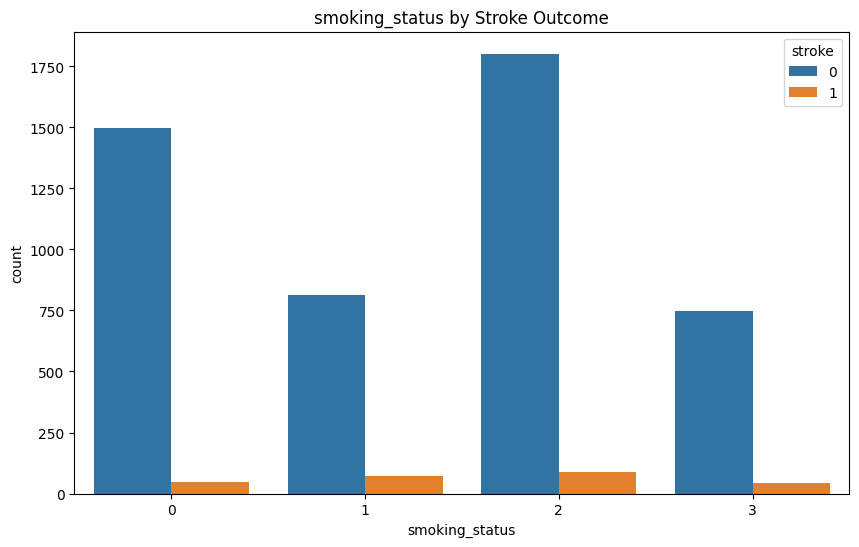

In [65]:
# Count plots of categorical features
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='stroke', data=data)
    plt.title(f'{feature} by Stroke Outcome')
    plt.show()


##5.Training the model & Evaluating the model

In [79]:
# Split the data into features and target variable
X = data.drop(['id', 'stroke'], axis=1)
y = data['stroke']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
# Define undersampling techniques
undersampling_techniques = {
    "ClusterCentroids": ClusterCentroids(random_state=0),
    "RandomUnderSampler": RandomUnderSampler(random_state=0),
    "NearMiss-1": NearMiss(version=1),
    "NearMiss-2": NearMiss(version=2),
    "NearMiss-3": NearMiss(version=3),
    "TomekLinks": TomekLinks(),
    "EditedNearestNeighbours": EditedNearestNeighbours(),
    "RepeatedEditedNearestNeighbours": RepeatedEditedNearestNeighbours(),
    "AllKNN": AllKNN(),
    "CondensedNearestNeighbour": CondensedNearestNeighbour(random_state=0),
    "OneSidedSelection": OneSidedSelection(random_state=0),
    "NeighbourhoodCleaningRule": NeighbourhoodCleaningRule(),
    "InstanceHardnessThreshold": InstanceHardnessThreshold(random_state=0, estimator=LogisticRegression())
}

# Define oversampling techniques
oversampling_methods = {
    'Random Over-Sampling': RandomOverSampler(),
    'SMOTE': SMOTE(),
    'ADASYN': ADASYN(),
    'Borderline-SMOTE': BorderlineSMOTE(),
    'SVMSMOTE': SVMSMOTE(),
    'KMeansSMOTE': KMeansSMOTE(cluster_balance_threshold=0.1, k_neighbors=5),
    'SMOTEENN': SMOTEENN(),
    'SMOTETomek': SMOTETomek()
}

# Define model
model = {"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)}


Evaluating model on imbalanced data (Baseline)

Model: XGBoost on imbalanced data
Accuracy: 0.9393346379647749
Precision: 0.5
Recall: 0.0967741935483871
F1 Score: 0.16216216216216217
ROC AUC Score: 0.796236559139785

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.50      0.10      0.16        62

    accuracy                           0.94      1022
   macro avg       0.72      0.55      0.57      1022
weighted avg       0.92      0.94      0.92      1022



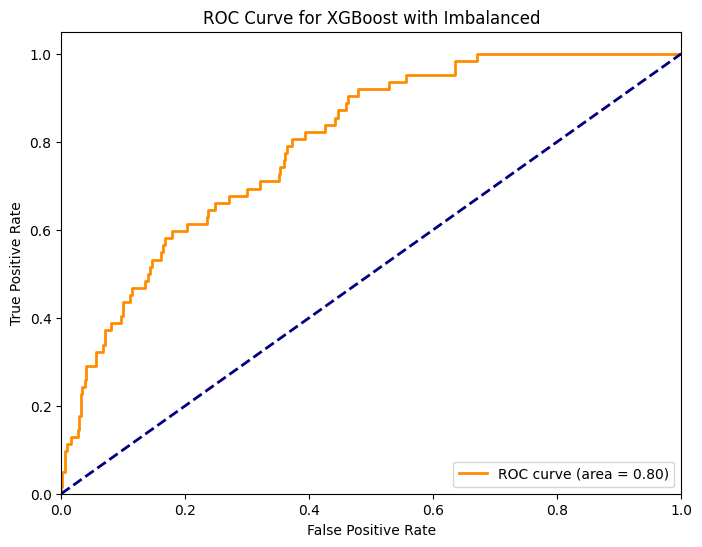

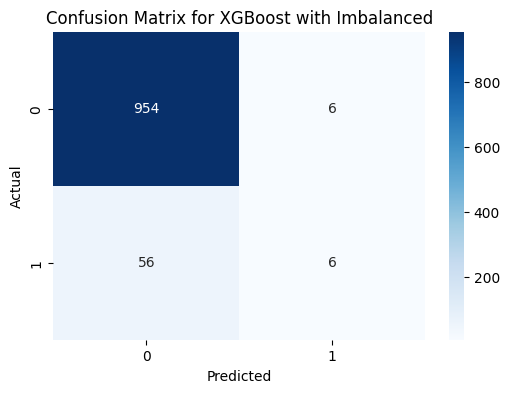


Evaluating model with Oversampling Technique: Random Over-Sampling

Model: XGBoost with Random Over-Sampling
Accuracy: 0.9246575342465754
Precision: 0.32558139534883723
Recall: 0.22580645161290322
F1 Score: 0.26666666666666666
ROC AUC Score: 0.7839045698924731
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       960
           1       0.33      0.23      0.27        62

    accuracy                           0.92      1022
   macro avg       0.64      0.60      0.61      1022
weighted avg       0.91      0.92      0.92      1022



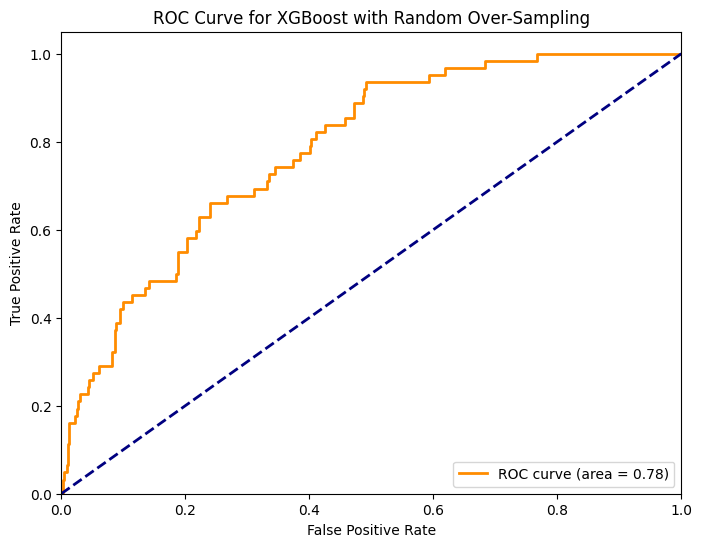

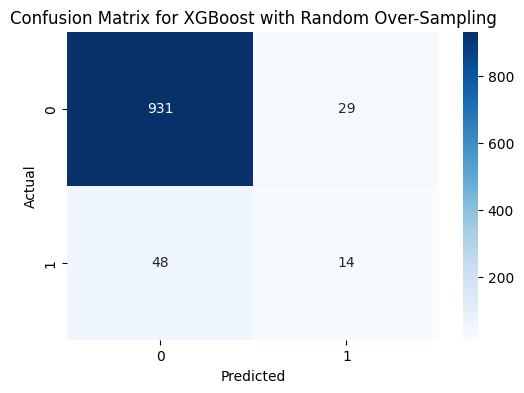


Evaluating model with Oversampling Technique: SMOTE

Model: XGBoost with SMOTE
Accuracy: 0.9187866927592955
Precision: 0.13793103448275862
Recall: 0.06451612903225806
F1 Score: 0.08791208791208792
ROC AUC Score: 0.7863575268817203
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       960
           1       0.14      0.06      0.09        62

    accuracy                           0.92      1022
   macro avg       0.54      0.52      0.52      1022
weighted avg       0.89      0.92      0.90      1022



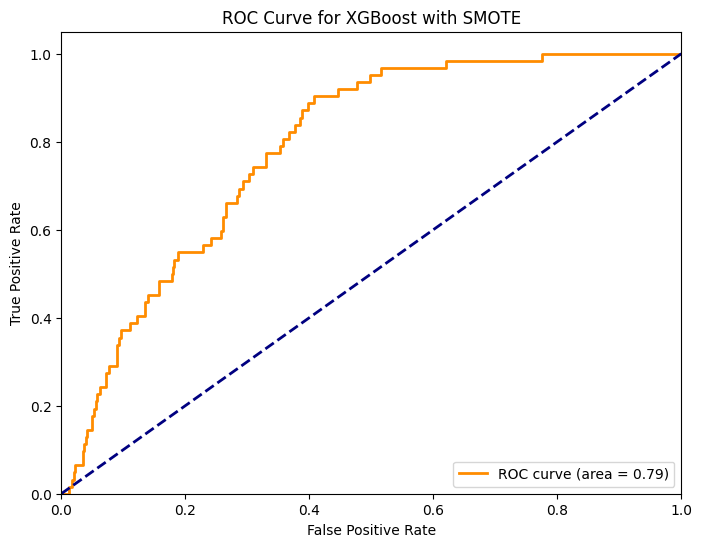

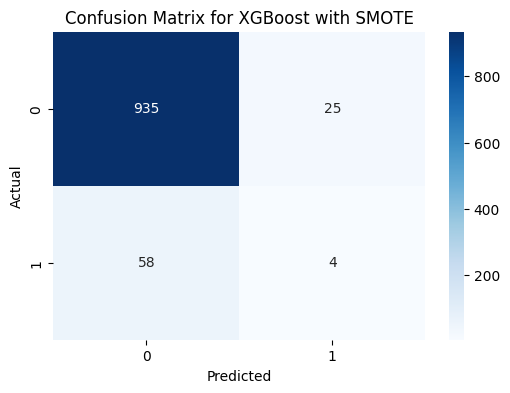


Evaluating model with Oversampling Technique: ADASYN

Model: XGBoost with ADASYN
Accuracy: 0.9099804305283757
Precision: 0.08333333333333333
Recall: 0.04838709677419355
F1 Score: 0.061224489795918366
ROC AUC Score: 0.7582325268817205
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       960
           1       0.08      0.05      0.06        62

    accuracy                           0.91      1022
   macro avg       0.51      0.51      0.51      1022
weighted avg       0.89      0.91      0.90      1022



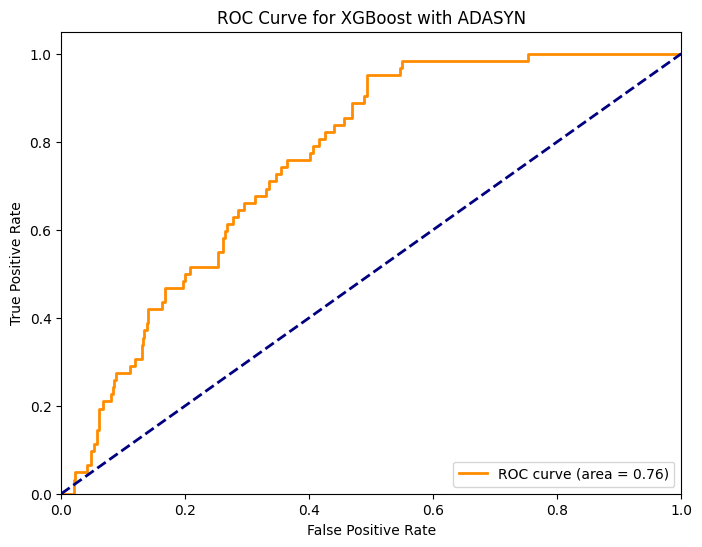

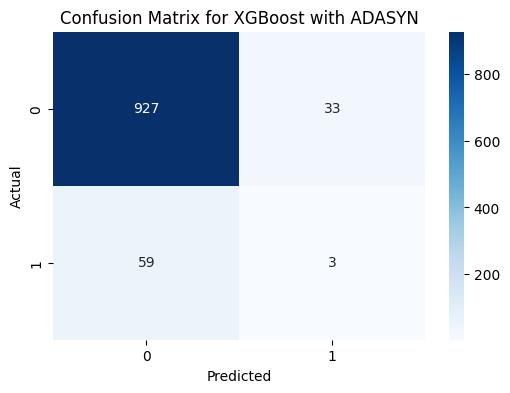


Evaluating model with Oversampling Technique: Borderline-SMOTE

Model: XGBoost with Borderline-SMOTE
Accuracy: 0.9217221135029354
Precision: 0.15384615384615385
Recall: 0.06451612903225806
F1 Score: 0.09090909090909091
ROC AUC Score: 0.7812836021505376
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       960
           1       0.15      0.06      0.09        62

    accuracy                           0.92      1022
   macro avg       0.55      0.52      0.53      1022
weighted avg       0.89      0.92      0.91      1022



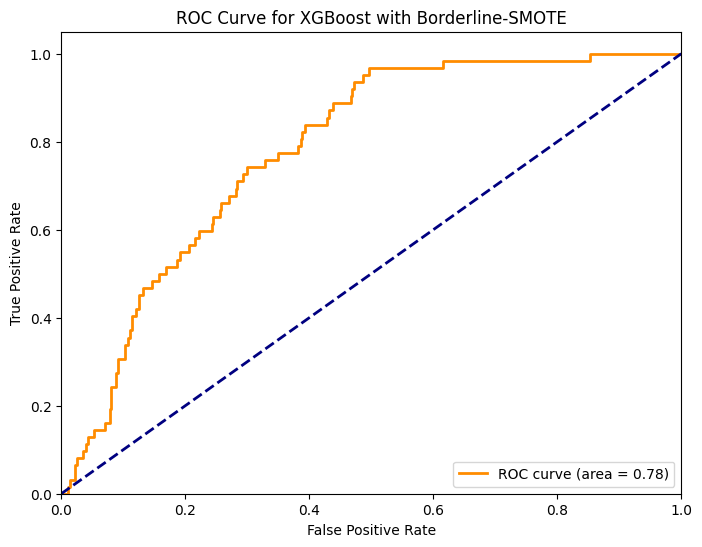

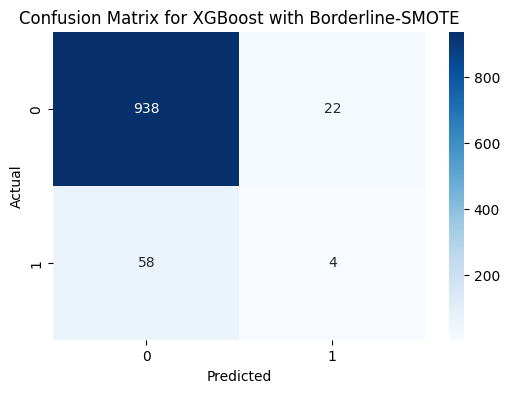


Evaluating model with Oversampling Technique: SVMSMOTE

Model: XGBoost with SVMSMOTE
Accuracy: 0.9227005870841487
Precision: 0.13043478260869565
Recall: 0.04838709677419355
F1 Score: 0.07058823529411765
ROC AUC Score: 0.7784778225806451
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       960
           1       0.13      0.05      0.07        62

    accuracy                           0.92      1022
   macro avg       0.54      0.51      0.52      1022
weighted avg       0.89      0.92      0.91      1022



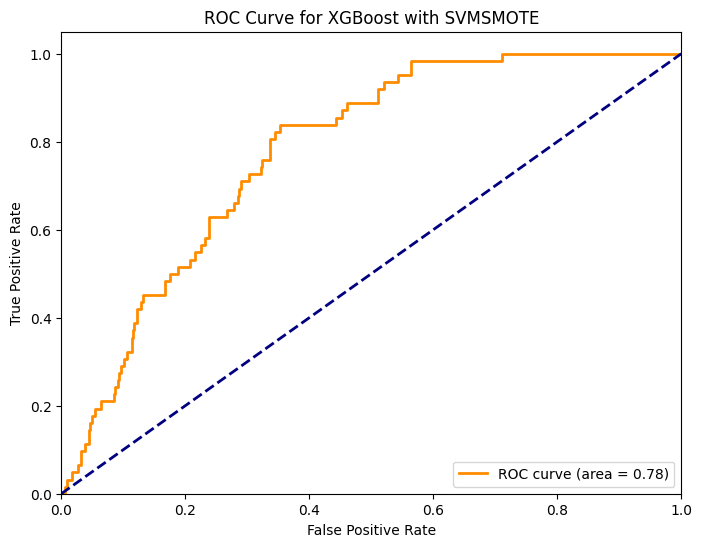

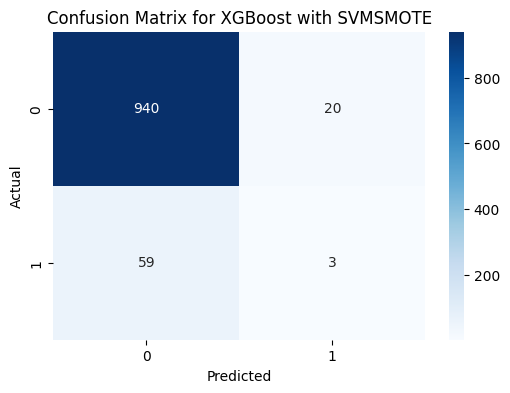


Evaluating model with Oversampling Technique: KMeansSMOTE

Model: XGBoost with KMeansSMOTE
Accuracy: 0.9295499021526419
Precision: 0.32142857142857145
Recall: 0.14516129032258066
F1 Score: 0.2
ROC AUC Score: 0.8091565860215053
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       960
           1       0.32      0.15      0.20        62

    accuracy                           0.93      1022
   macro avg       0.63      0.56      0.58      1022
weighted avg       0.91      0.93      0.92      1022



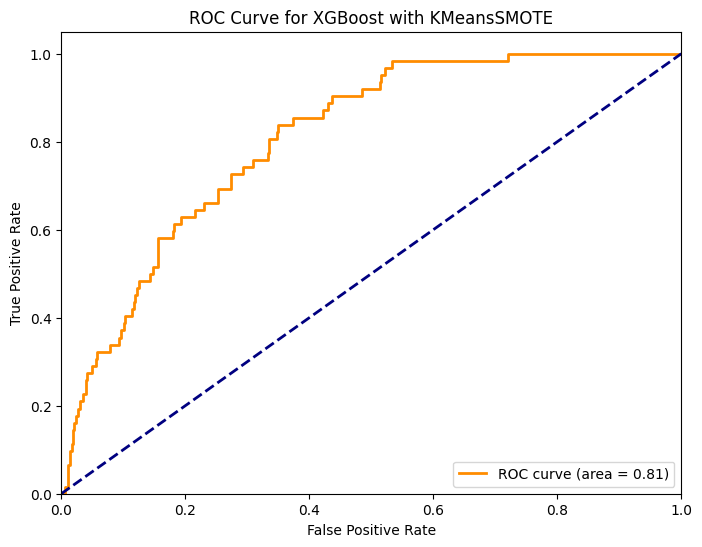

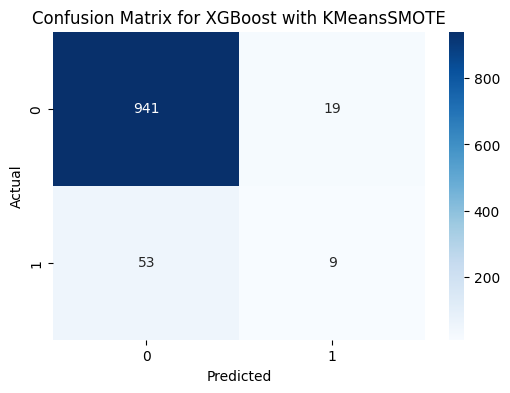


Evaluating model with Oversampling Technique: SMOTEENN

Model: XGBoost with SMOTEENN
Accuracy: 0.8796477495107632
Precision: 0.17894736842105263
Recall: 0.27419354838709675
F1 Score: 0.21656050955414013
ROC AUC Score: 0.813239247311828
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       960
           1       0.18      0.27      0.22        62

    accuracy                           0.88      1022
   macro avg       0.57      0.60      0.58      1022
weighted avg       0.90      0.88      0.89      1022



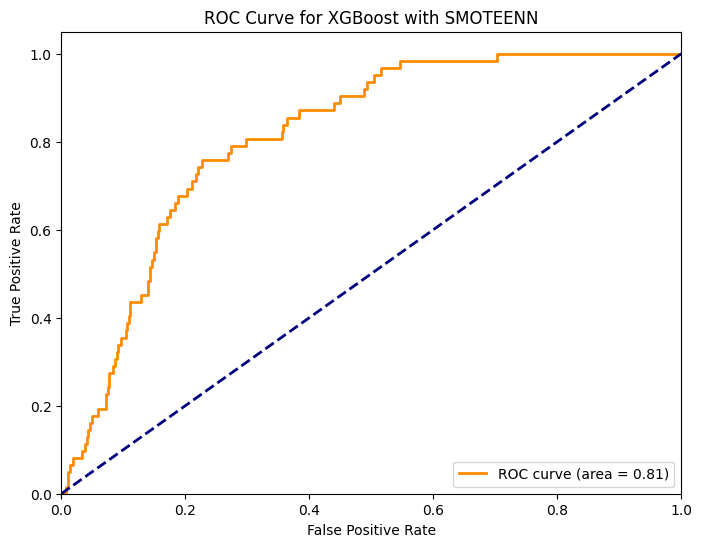

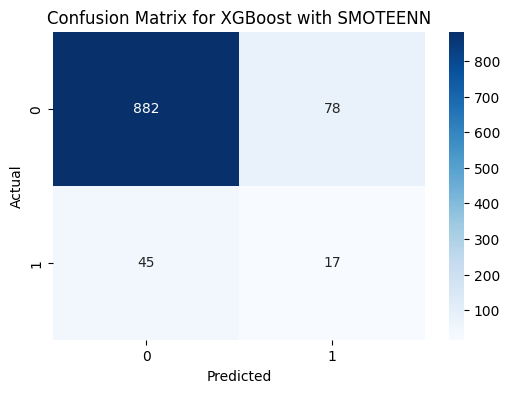


Evaluating model with Oversampling Technique: SMOTETomek

Model: XGBoost with SMOTETomek
Accuracy: 0.9168297455968689
Precision: 0.12903225806451613
Recall: 0.06451612903225806
F1 Score: 0.08602150537634409
ROC AUC Score: 0.8004032258064515
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       960
           1       0.13      0.06      0.09        62

    accuracy                           0.92      1022
   macro avg       0.54      0.52      0.52      1022
weighted avg       0.89      0.92      0.90      1022



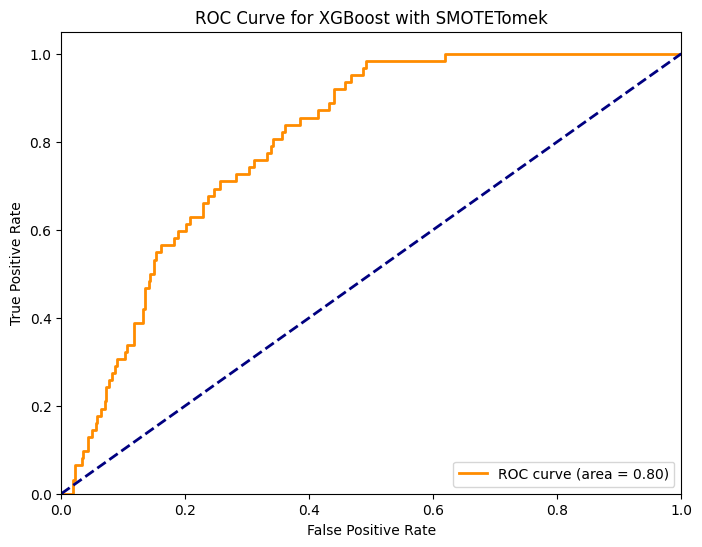

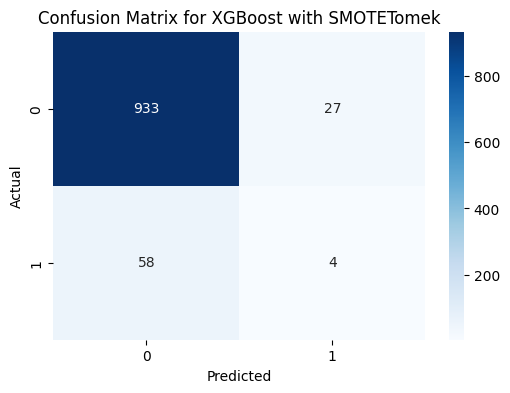


Evaluating model with Undersampling Technique: ClusterCentroids

Model: XGBoost with ClusterCentroids
Accuracy: 0.42367906066536204
Precision: 0.09399075500770417
Recall: 0.9838709677419355
F1 Score: 0.17158931082981715
ROC AUC Score: 0.8063256048387096
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.39      0.56       960
           1       0.09      0.98      0.17        62

    accuracy                           0.42      1022
   macro avg       0.55      0.69      0.36      1022
weighted avg       0.94      0.42      0.53      1022



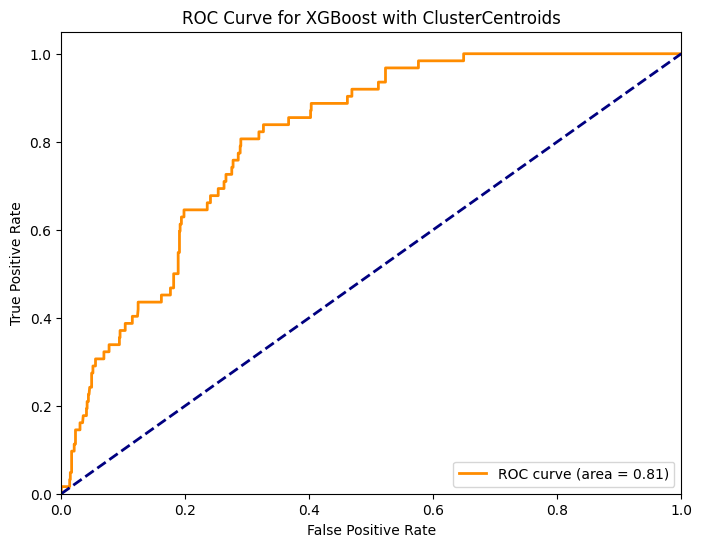

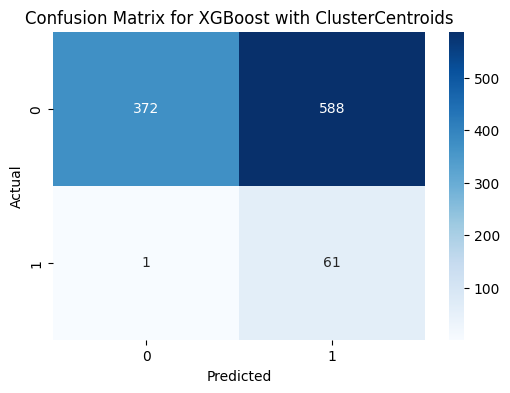


Evaluating model with Undersampling Technique: RandomUnderSampler

Model: XGBoost with RandomUnderSampler
Accuracy: 0.7103718199608611
Precision: 0.14759036144578314
Recall: 0.7903225806451613
F1 Score: 0.24873096446700507
ROC AUC Score: 0.8158770161290323
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82       960
           1       0.15      0.79      0.25        62

    accuracy                           0.71      1022
   macro avg       0.56      0.75      0.53      1022
weighted avg       0.93      0.71      0.79      1022



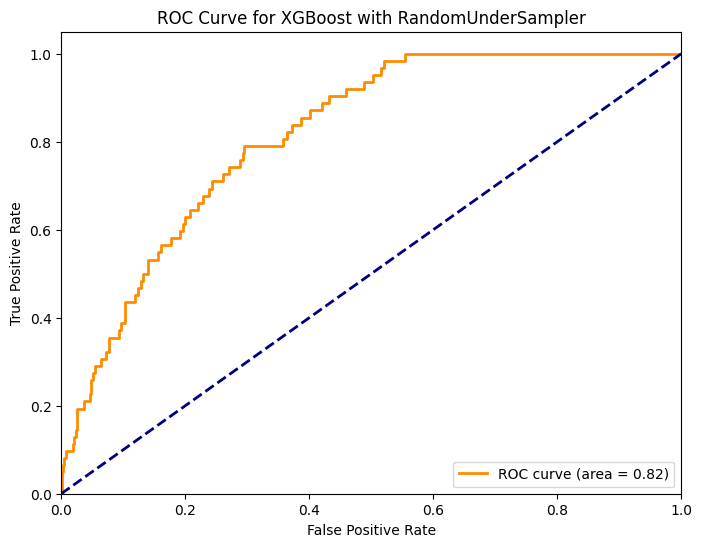

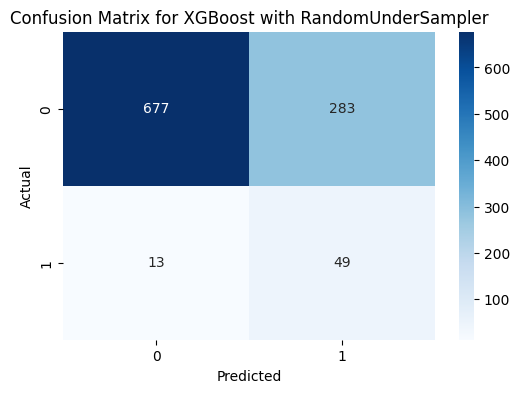


Evaluating model with Undersampling Technique: NearMiss-1

Model: XGBoost with NearMiss-1
Accuracy: 0.3101761252446184
Precision: 0.06377204884667571
Recall: 0.7580645161290323
F1 Score: 0.11764705882352941
ROC AUC Score: 0.5659106182795699
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.28      0.43       960
           1       0.06      0.76      0.12        62

    accuracy                           0.31      1022
   macro avg       0.51      0.52      0.28      1022
weighted avg       0.89      0.31      0.41      1022



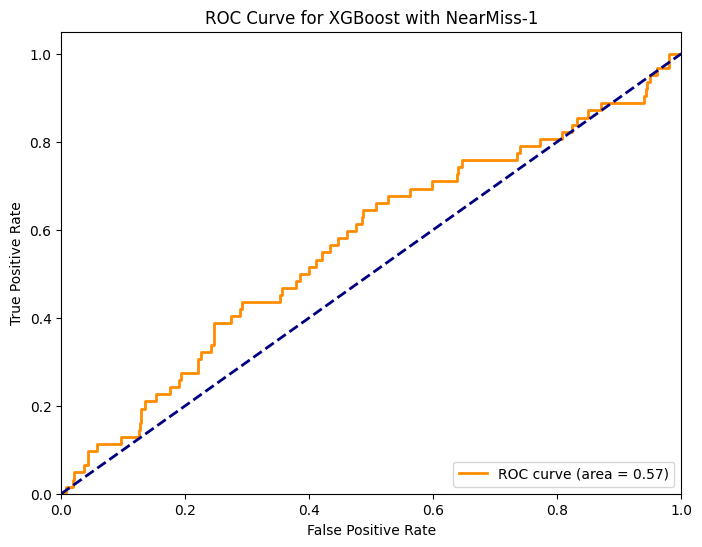

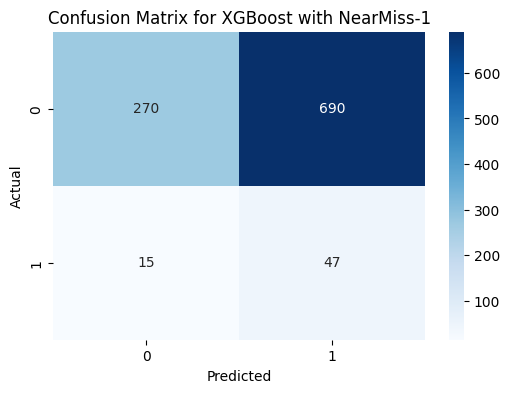


Evaluating model with Undersampling Technique: NearMiss-2

Model: XGBoost with NearMiss-2
Accuracy: 0.22700587084148727
Precision: 0.0645933014354067
Recall: 0.8709677419354839
F1 Score: 0.12026726057906459
ROC AUC Score: 0.4776041666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.19      0.31       960
           1       0.06      0.87      0.12        62

    accuracy                           0.23      1022
   macro avg       0.51      0.53      0.22      1022
weighted avg       0.90      0.23      0.30      1022



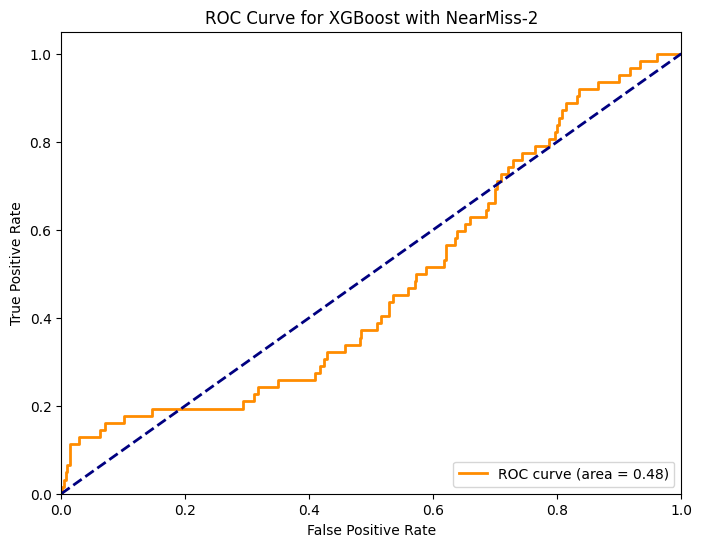

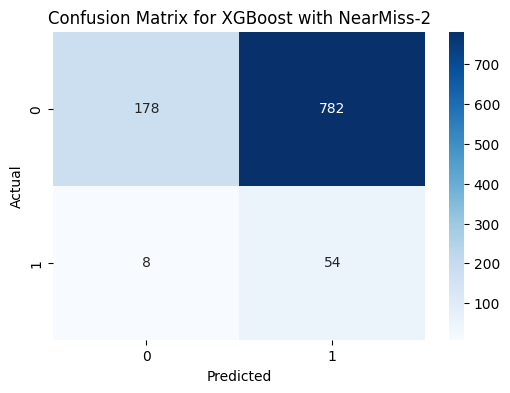


Evaluating model with Undersampling Technique: NearMiss-3

Model: XGBoost with NearMiss-3
Accuracy: 0.547945205479452
Precision: 0.09183673469387756
Recall: 0.7258064516129032
F1 Score: 0.16304347826086957
ROC AUC Score: 0.655241935483871
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.54      0.69       960
           1       0.09      0.73      0.16        62

    accuracy                           0.55      1022
   macro avg       0.53      0.63      0.43      1022
weighted avg       0.91      0.55      0.66      1022



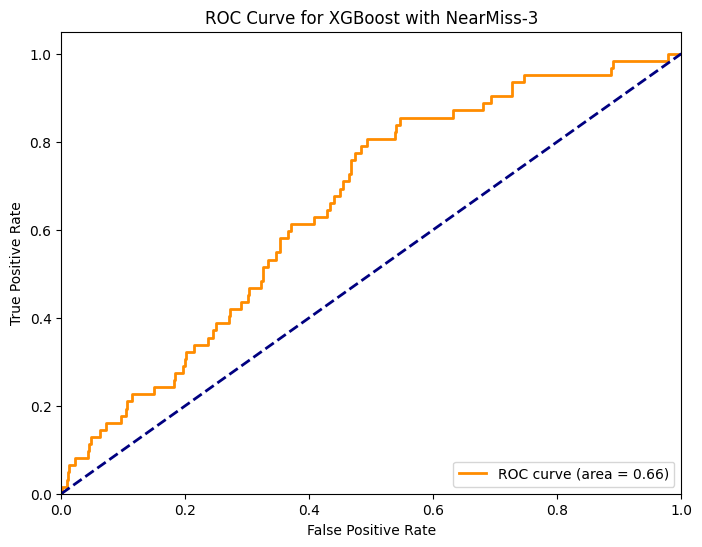

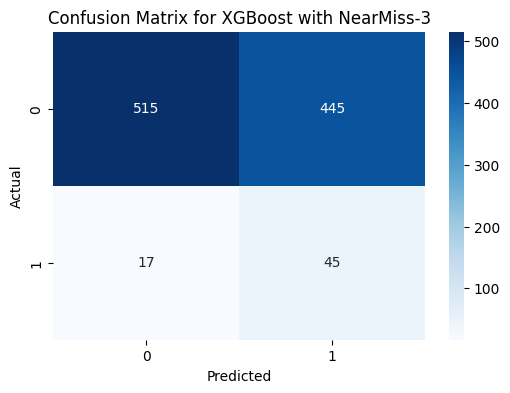


Evaluating model with Undersampling Technique: TomekLinks

Model: XGBoost with TomekLinks
Accuracy: 0.9344422700587084
Precision: 0.35294117647058826
Recall: 0.0967741935483871
F1 Score: 0.1518987341772152
ROC AUC Score: 0.8049899193548388
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.35      0.10      0.15        62

    accuracy                           0.93      1022
   macro avg       0.65      0.54      0.56      1022
weighted avg       0.91      0.93      0.92      1022



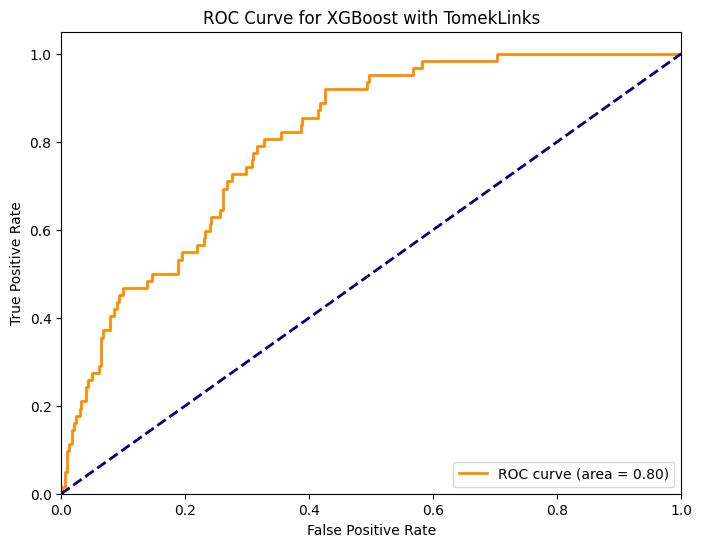

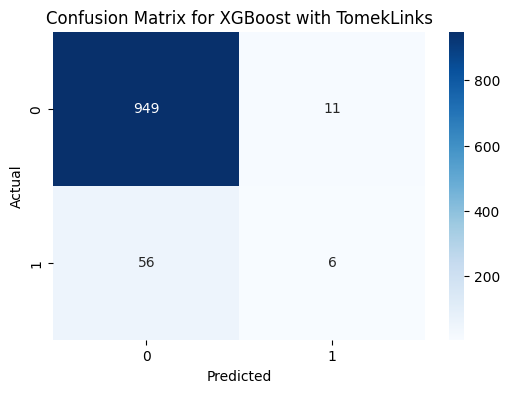


Evaluating model with Undersampling Technique: EditedNearestNeighbours

Model: XGBoost with EditedNearestNeighbours
Accuracy: 0.9275929549902152
Precision: 0.3235294117647059
Recall: 0.1774193548387097
F1 Score: 0.22916666666666666
ROC AUC Score: 0.8078461021505376
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       960
           1       0.32      0.18      0.23        62

    accuracy                           0.93      1022
   macro avg       0.64      0.58      0.60      1022
weighted avg       0.91      0.93      0.92      1022



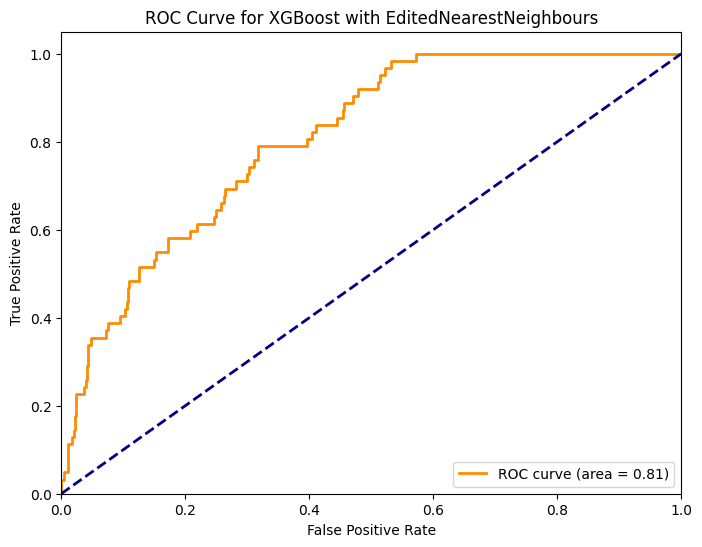

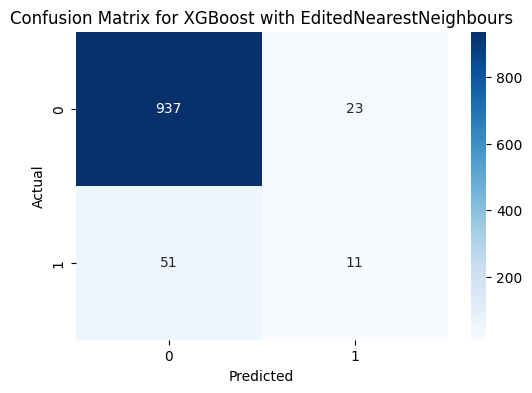


Evaluating model with Undersampling Technique: RepeatedEditedNearestNeighbours

Model: XGBoost with RepeatedEditedNearestNeighbours
Accuracy: 0.9090019569471625
Precision: 0.23728813559322035
Recall: 0.22580645161290322
F1 Score: 0.23140495867768596
ROC AUC Score: 0.8344758064516129
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       960
           1       0.24      0.23      0.23        62

    accuracy                           0.91      1022
   macro avg       0.59      0.59      0.59      1022
weighted avg       0.91      0.91      0.91      1022



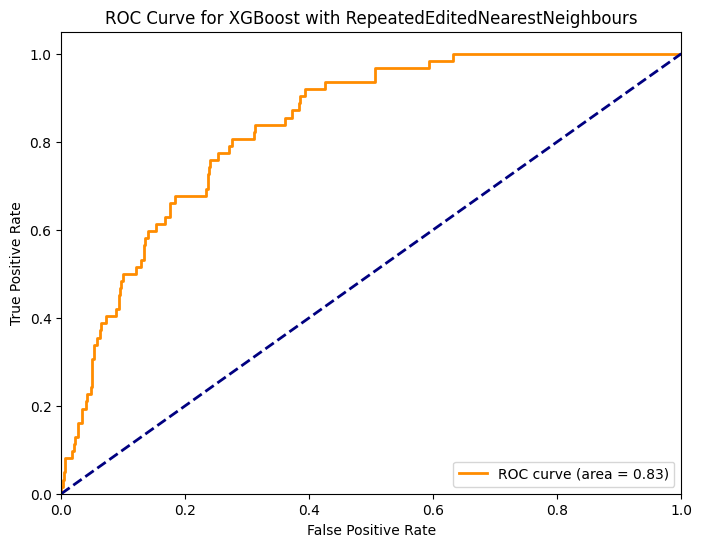

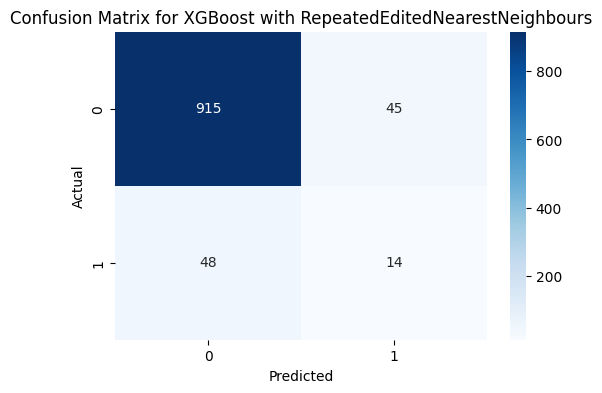


Evaluating model with Undersampling Technique: AllKNN

Model: XGBoost with AllKNN
Accuracy: 0.9275929549902152
Precision: 0.35
Recall: 0.22580645161290322
F1 Score: 0.27450980392156865
ROC AUC Score: 0.8227654569892473
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       960
           1       0.35      0.23      0.27        62

    accuracy                           0.93      1022
   macro avg       0.65      0.60      0.62      1022
weighted avg       0.91      0.93      0.92      1022



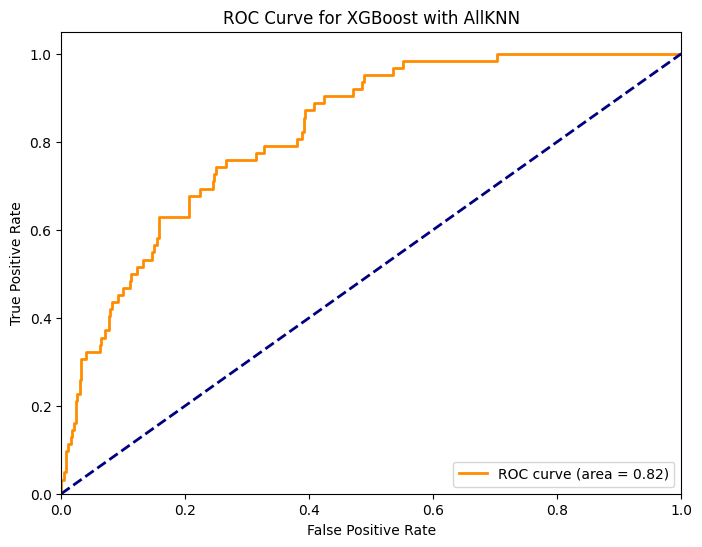

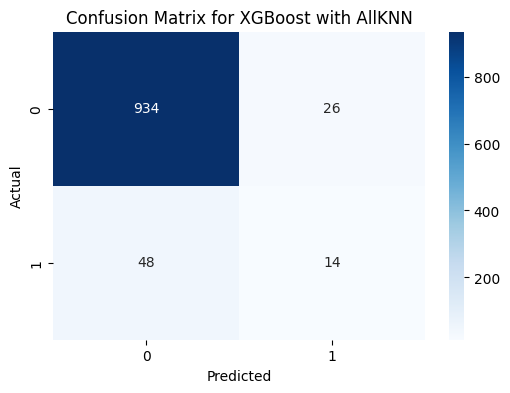


Evaluating model with Undersampling Technique: CondensedNearestNeighbour

Model: XGBoost with CondensedNearestNeighbour
Accuracy: 0.8992172211350293
Precision: 0.2191780821917808
Recall: 0.25806451612903225
F1 Score: 0.23703703703703705
ROC AUC Score: 0.7164818548387096
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       960
           1       0.22      0.26      0.24        62

    accuracy                           0.90      1022
   macro avg       0.59      0.60      0.59      1022
weighted avg       0.91      0.90      0.90      1022



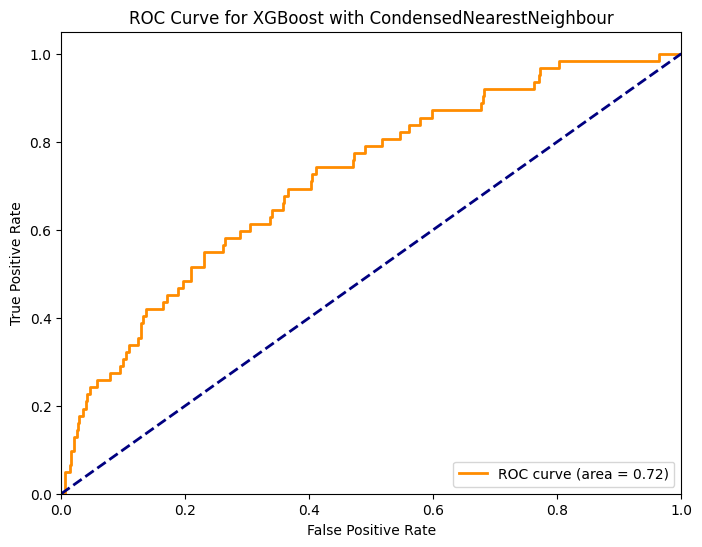

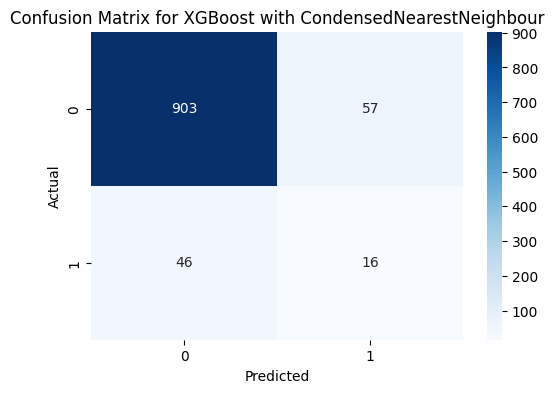


Evaluating model with Undersampling Technique: OneSidedSelection

Model: XGBoost with OneSidedSelection
Accuracy: 0.9344422700587084
Precision: 0.35294117647058826
Recall: 0.0967741935483871
F1 Score: 0.1518987341772152
ROC AUC Score: 0.8120631720430108
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.35      0.10      0.15        62

    accuracy                           0.93      1022
   macro avg       0.65      0.54      0.56      1022
weighted avg       0.91      0.93      0.92      1022



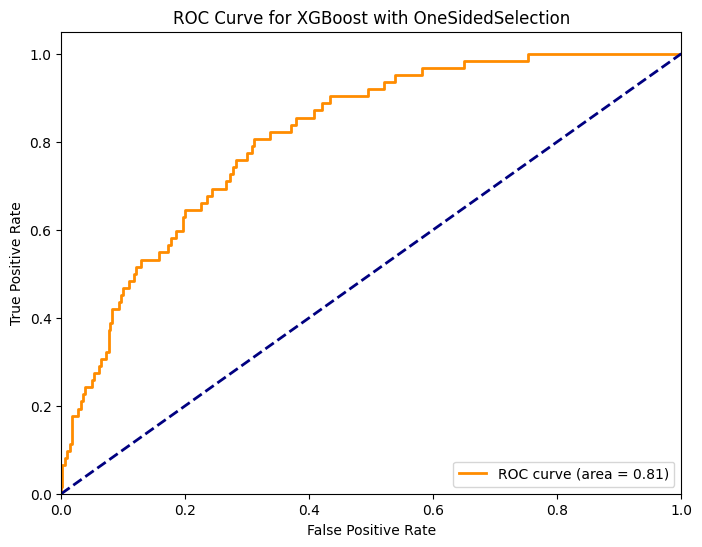

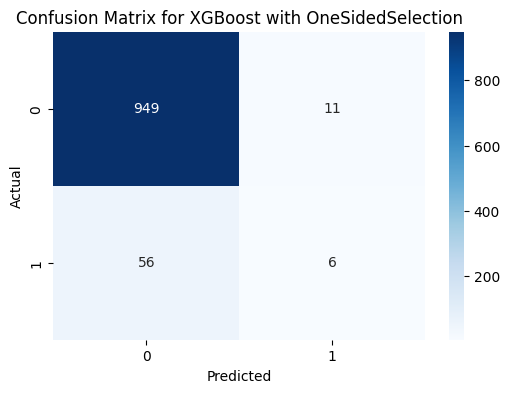


Evaluating model with Undersampling Technique: NeighbourhoodCleaningRule

Model: XGBoost with NeighbourhoodCleaningRule
Accuracy: 0.9315068493150684
Precision: 0.35714285714285715
Recall: 0.16129032258064516
F1 Score: 0.2222222222222222
ROC AUC Score: 0.8221102150537635
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       960
           1       0.36      0.16      0.22        62

    accuracy                           0.93      1022
   macro avg       0.65      0.57      0.59      1022
weighted avg       0.91      0.93      0.92      1022



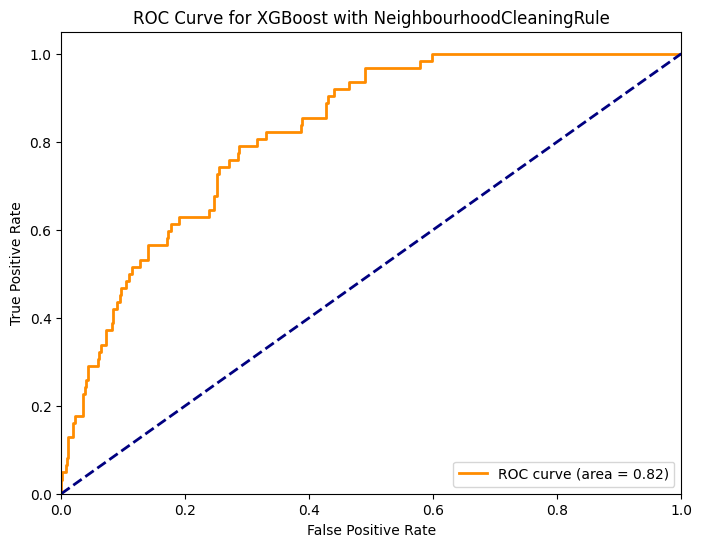

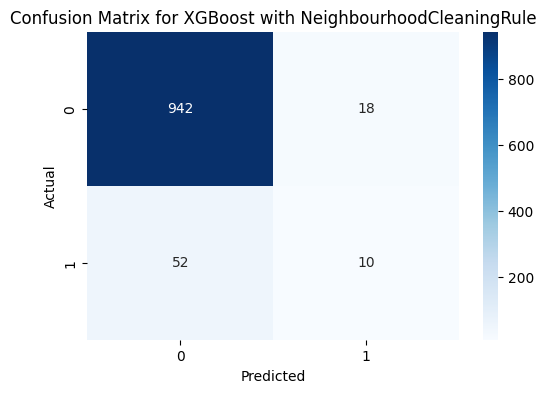


Evaluating model with Undersampling Technique: InstanceHardnessThreshold

Model: XGBoost with InstanceHardnessThreshold
Accuracy: 0.32093933463796476
Precision: 0.082010582010582
Recall: 1.0
F1 Score: 0.15158924205378974
ROC AUC Score: 0.6774193548387096
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.28      0.43       960
           1       0.08      1.00      0.15        62

    accuracy                           0.32      1022
   macro avg       0.54      0.64      0.29      1022
weighted avg       0.94      0.32      0.42      1022



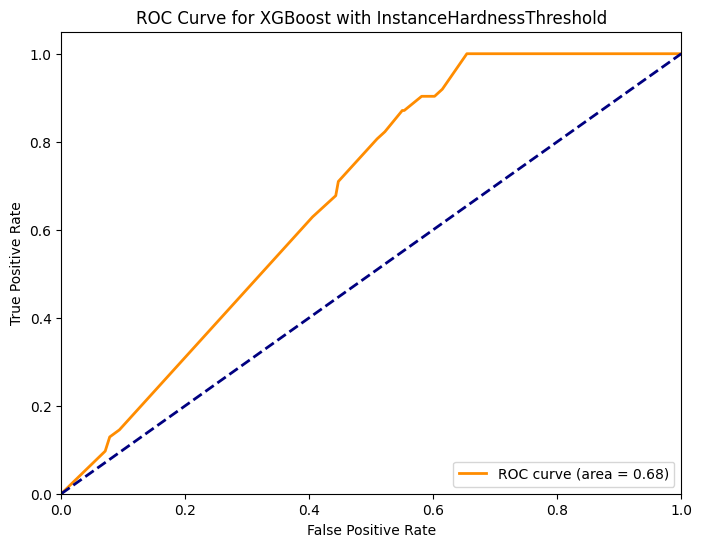

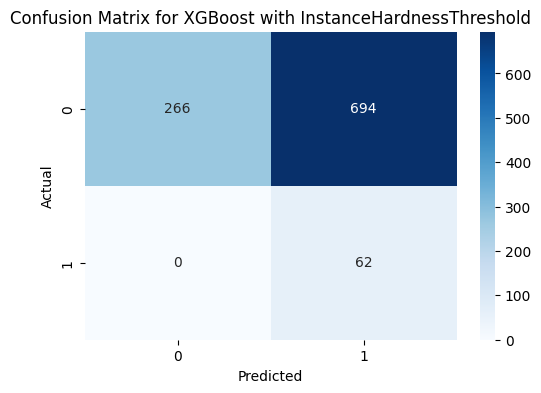

In [81]:
# Dictionary to store summary results
results = []

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    precision = classification_rep['1']['precision']
    recall = classification_rep['1']['recall']
    f1 = classification_rep['1']['f1-score']
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    return accuracy, precision, recall, f1, roc_auc, y_pred, y_pred_proba

# Function to plot ROC Curve
def plot_roc_curve(y_test, y_pred_proba, model_name, technique):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} with {technique}')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, model_name, technique):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} with {technique}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 1. Evaluate on Imbalanced Data (Baseline)
print("\nEvaluating model on imbalanced data (Baseline)")
# Access the XGBClassifier object using its key 'XGBoost'
model['XGBoost'].fit(X_train_scaled, y_train)
accuracy, precision, recall, f1, roc_auc, y_pred, y_pred_proba = evaluate_model(model['XGBoost'], X_test_scaled, y_test)

results.append({
    "Technique": "Imbalanced",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC Score": roc_auc
})

# Display metrics
print(f"\nModel: XGBoost on imbalanced data")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot ROC Curve and Confusion Matrix
if roc_auc is not None:
    plot_roc_curve(y_test, y_pred_proba, "XGBoost", "Imbalanced")
plot_confusion_matrix(y_test, y_pred, "XGBoost", "Imbalanced")

# 2. Apply Oversampling Techniques
for technique_name, technique in oversampling_methods.items():
    print(f"\nEvaluating model with Oversampling Technique: {technique_name}")
    # Resample the training data
    X_res, y_res = technique.fit_resample(X_train_scaled, y_train)

    # Train the model
    # Access the XGBClassifier object using its key 'XGBoost'
    model['XGBoost'].fit(X_res, y_res)

    # Evaluate the model
    accuracy, precision, recall, f1, roc_auc, y_pred, y_pred_proba = evaluate_model(model['XGBoost'], X_test_scaled, y_test) # Pass the XGBClassifier object to evaluate_model


    # Store the results
    results.append({
        "Technique": technique_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC Score": roc_auc
    })

    # Display metrics
    print(f"\nModel: XGBoost with {technique_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Plot ROC Curve and Confusion Matrix
    if roc_auc is not None:
        plot_roc_curve(y_test, y_pred_proba, "XGBoost", technique_name)
    plot_confusion_matrix(y_test, y_pred, "XGBoost", technique_name)

# 3. Apply Undersampling Techniques
for technique_name, technique in undersampling_techniques.items():
    print(f"\nEvaluating model with Undersampling Technique: {technique_name}")
    # Resample the training data
    X_res, y_res = technique.fit_resample(X_train_scaled, y_train)

    # Train the model
    # Access the XGBClassifier object using its key 'XGBoost' to call the fit method.
    model['XGBoost'].fit(X_res, y_res)

    # Evaluate the model
    accuracy, precision, recall, f1, roc_auc, y_pred, y_pred_proba = evaluate_model(model['XGBoost'], X_test_scaled, y_test)

    # Store the results
    results.append({
        "Technique": technique_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC Score": roc_auc
    })

    # Display metrics
    print(f"\nModel: XGBoost with {technique_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Plot ROC Curve and Confusion Matrix
    if roc_auc is not None:
        plot_roc_curve(y_test, y_pred_proba, "XGBoost", technique_name)
    plot_confusion_matrix(y_test, y_pred, "XGBoost", technique_name)



In [82]:
# Compare All Results
from tabulate import tabulate
results_df = pd.DataFrame(results).sort_values(by='ROC AUC Score', ascending=False)

print("\nSummary of All Results:")
print(tabulate(results_df, headers='keys', tablefmt='psql', showindex=False))


Summary of All Results:
+---------------------------------+------------+-------------+-----------+------------+-----------------+
| Technique                       |   Accuracy |   Precision |    Recall |   F1 Score |   ROC AUC Score |
|---------------------------------+------------+-------------+-----------+------------+-----------------|
| RepeatedEditedNearestNeighbours |   0.909002 |   0.237288  | 0.225806  |  0.231405  |        0.834476 |
| AllKNN                          |   0.927593 |   0.35      | 0.225806  |  0.27451   |        0.822765 |
| NeighbourhoodCleaningRule       |   0.931507 |   0.357143  | 0.16129   |  0.222222  |        0.82211  |
| RandomUnderSampler              |   0.710372 |   0.14759   | 0.790323  |  0.248731  |        0.815877 |
| SMOTEENN                        |   0.879648 |   0.178947  | 0.274194  |  0.216561  |        0.813239 |
| OneSidedSelection               |   0.934442 |   0.352941  | 0.0967742 |  0.151899  |        0.812063 |
| KMeansSMOTE        